In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
abc_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/abc_da_de_table_peaks.csv"
nearest_file = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/nearest_da_de_table_peaks.csv"

In [3]:
libs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]

In [4]:
def read_and_filter_df(filename, libraries):
    df = pd.read_csv(filename)
    df = df.dropna()
    # proportional query
    query = " & ".join([
        f"((`{lib}_log2FoldChange_act`<0) & (`{lib}_log2FoldChange_exp`<0) | (`{lib}_log2FoldChange_act`>0) & (`{lib}_log2FoldChange_exp`>0))"
        for lib in libraries
        ])
    df = df.query(query)
    return df

def merge_multi_fragment_into_one(merge_df, libs):
    # merge overlapping locations
    # sort the dataframe by chromosomal coordinates
    merge_df_locations = merge_df.chrom_coord.str.split("_", expand=True)
    merge_df_locations.columns = ["chr", "start", "end"]
    merge_df_locations = merge_df_locations.astype({'start': 'int32', 'end': 'int32'})
    merge_df = merge_df.merge(merge_df_locations, left_index=True, right_index=True)
    merge_df = merge_df.sort_values(["chr", "start", "end"])

    dict_function = {
        "chrom_coord": lambda x: list(x)[0],
        "gene_name": lambda x: list(x)[0]
    }
    for lib in libs:
        dict_function[f"{lib}_act"]= max, # max activity value for each fragment
        dict_function[f"{lib}_padj_act"] = min, # min significance value for each fragment
        dict_function[f"{lib}_log2FoldChange_act"] = lambda x: max(x) if all(i>0 for i in x) else min(x),
        dict_function[f"{lib}_padj_exp"] = min, # min significance value for each fragment
        dict_function[f"{lib}_log2FoldChange_exp"] = lambda x: max(x) if all(i>0 for i in x) else min(x),
        
    grouped_dfs = []
    for group, df in merge_df.groupby(["chr", "gene_name"]): # https://stackoverflow.com/questions/46732760/merge-rows-pandas-dataframe-based-on-condition
        grouped_df = df.groupby(((df.start  - df.end.shift(1)) > 0).cumsum()).agg({k:v for k,v in dict_function.items() if k in merge_df.columns})
        grouped_df["chr"] = group[0]
        grouped_df["gene_name"] = group[1]
        grouped_dfs.append(grouped_df)

    merged_df = pd.concat(grouped_dfs)
    return merged_df.drop(columns="chr")

In [5]:
abc_df = read_and_filter_df(abc_file, libs)
nearest_df = read_and_filter_df(nearest_file, libs)

In [6]:
df = pd.concat((abc_df, nearest_df)).drop_duplicates(subset=["chrom_coord", "gene_name"])
df = merge_multi_fragment_into_one(df, libs)
df["eg_pairs"] = df.chrom_coord + "::" + df.gene_name
df = df.set_index("eg_pairs")

In [53]:
plot_df = df.loc[:, [f"{lib}_log2FoldChange_{t}" for lib in libs for t in ["act", "exp"]]]
annot_df = df.loc[:, [f"{lib}_padj_{t}" for lib in libs for t in ["act", "exp"]]]

plot_df.columns = plot_df.columns.droplevel(1)

<AxesSubplot:ylabel='eg_pairs'>

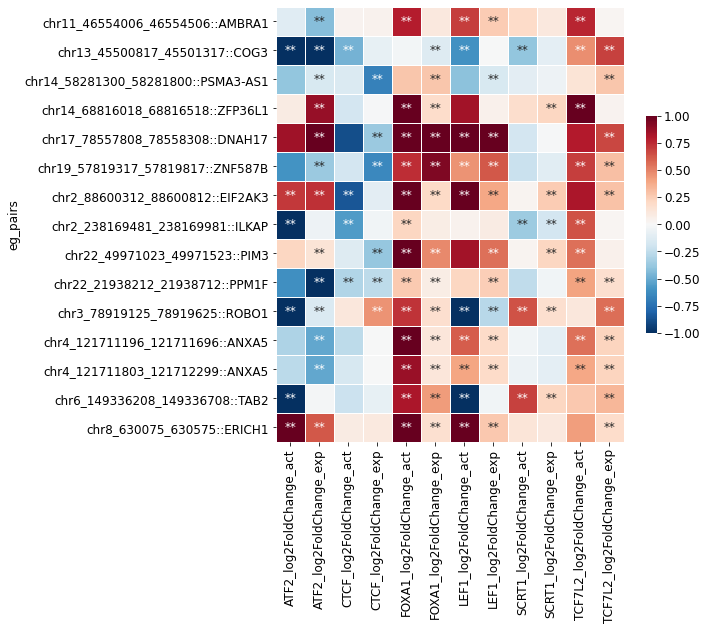

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    plot_df, cmap="RdBu_r", center=0, square=True, 
    cbar_kws={"shrink":0.5}, vmin=-1, vmax=1, linewidths=1., linecolor="w", 
    annot=annot_df.applymap(lambda x: "**" if x<0.05 else ""), fmt = '', 
    ax=ax
    )

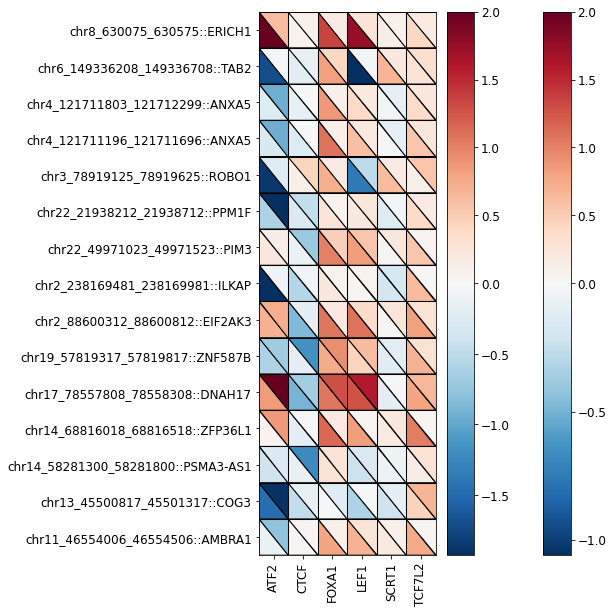

In [94]:
from matplotlib.tri import Triangulation
from matplotlib import colors
fig, ax = plt.subplots(figsize=(6, 10))

M = len(plot_df.columns)//2
N = len(plot_df)
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)
act = plot_df.loc[:, [c for c in plot_df.columns if "_act" in c]].values
act = act.ravel() # [:-1, :-1]
exp = plot_df.loc[:, [c for c in plot_df.columns if "_exp" in c]].values
exp = exp.ravel() # [:-1, :-1]

divnorm_act=colors.TwoSlopeNorm(vmin=min(act), vcenter=0., vmax=2)
divnorm_exp=colors.TwoSlopeNorm(vmin=min(exp), vcenter=0., vmax=2)


triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
img1 = plt.tripcolor(triang1, act, cmap=plt.get_cmap('RdBu_r'), norm=divnorm_act, edgecolors="k", linewidths=1.05)
img2 = plt.tripcolor(triang2, exp, cmap=plt.get_cmap('RdBu_r'), norm=divnorm_exp, edgecolors="k", linewidths=1.05)

plt.colorbar(img2, pad=0.19)
plt.colorbar(img1)
plt.xlim(x[0], x[-1])
plt.ylim(y[0], y[-1])
plt.xticks(x[:-1]+0.5, [c.replace("_log2FoldChange_act", "") for c in plot_df.columns if "_act" in c], rotation=90)
plt.yticks(y[:-1]+0.5, plot_df.index)
plt.show()

In [19]:
abc_df.loc[abc_df.ATF2_log2FoldChange_act<0]

,chrom_coord,gene_name,per_gene_corr,CC_act,ATF2_act,CTCF_act,FOXA1_act,LEF1_act,SCRT1_act,TCF7L2_act,...,SCRT1_log2FoldChange_exp,TCF7L2_log2FoldChange_exp,16P12_1_log2FoldChange_exp,ATF2_padj_exp,CTCF_padj_exp,FOXA1_padj_exp,LEF1_padj_exp,SCRT1_padj_exp,TCF7L2_padj_exp,16P12_1_padj_exp
0,chr7_158818595_158819089,THAP5P1,0.833333,1.035458,0.125184,1.576538,1.550319,0.028383,1.702446,0.860666,...,0.484857,-0.667229,0.369814,2.374734e-01,0.534255,7.642090e-01,0.736127,6.830379e-01,6.023529e-01,0.753981
1,chr3_100105778_100106278,CMSS1,0.833333,4.234542,2.184595,3.513183,4.536054,4.389706,4.009267,4.985528,...,0.049591,0.345742,0.149854,4.440584e-30,0.000530,4.609295e-06,0.077271,4.554712e-01,1.430792e-19,0.000087
2,chr3_152379218_152379718,Y_RNA,0.738095,1.931250,0.114062,1.820806,2.204690,1.168577,2.278344,1.845792,...,1.270981,-0.291134,-0.309827,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr3_152379318_152379775,Y_RNA,0.738095,1.925437,0.106940,1.797228,2.198738,1.142236,2.232455,1.828252,...,1.270981,-0.291134,-0.309827,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr3_152379318_152379775,MBNL1,0.714286,1.925437,0.106940,1.797228,2.198738,1.142236,2.232455,1.828252,...,-0.050846,0.121120,-0.091996,1.927445e-09,0.162834,3.185385e-01,0.019821,7.061513e-01,8.711430e-02,0.272016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,chr11_57493699_57494199,UBE2L6,-0.571429,3.562769,1.856032,3.158577,3.859090,4.013418,3.251520,4.035335,...,-0.721634,-2.070505,0.213857,2.668868e-68,0.000002,4.435129e-27,0.129363,2.109830e-07,1.298136e-32,0.091251
143,chr8_46617217_46617717,ENSG00000255366,-0.619048,4.934769,2.795126,4.543962,5.647602,5.600322,4.669582,5.529039,...,0.301948,-0.697866,-0.298757,3.488600e-01,0.941346,3.790340e-05,0.392923,1.768432e-01,1.844152e-03,0.212463
144,chrX_46963496_46963996,USP11,-0.619048,3.197527,1.819054,2.990833,4.178967,0.281223,3.919614,3.502314,...,-0.424543,0.176954,0.046850,0.000000e+00,0.002557,1.330527e-08,0.200503,4.303581e-16,1.784994e-11,0.151626
145,chrX_46963496_46963996,CHST7,-0.619048,3.197527,1.819054,2.990833,4.178967,0.281223,3.919614,3.502314,...,0.220850,-0.280931,0.041562,1.197542e-23,0.247076,1.136882e-02,0.082272,1.900807e-01,7.138030e-02,0.844555
